In [91]:
# https://thedinogame.com/fullscreen/

In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [6]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [25]:
!pip install gymnasium

In [7]:
!pip install pillow

In [51]:
!pip install mss pydirectinput pytesseract

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [9]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down', 
            2: 'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done()
        observation = self.get_observation()
        reward = 1
        info = {}

        # Add a `truncated` flag (assuming no special truncation conditions)
        truncated = False

        return observation, reward, done, truncated, info

        
    
    def reset(self, seed=None):
    # Ensure the seed is passed correctly
        super().reset(seed=seed)
    
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
    
        observation = self.get_observation()
        info = {}  # Empty info dictionary as required
        return observation, info

    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE','Go A','GARN']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [10]:
env = WebGame()

In [11]:
obs=env.get_observation()

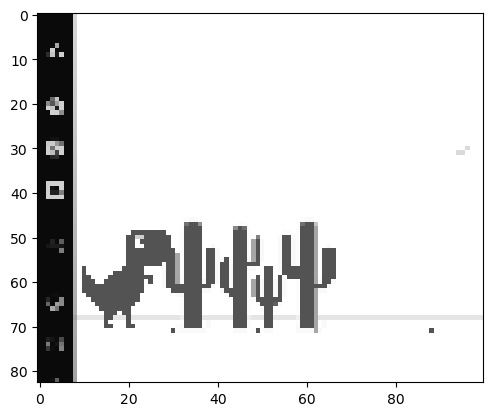

In [12]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [13]:
done, done_cap = env.get_done()

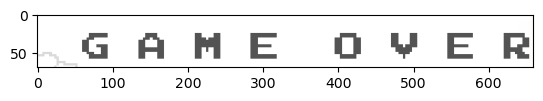

In [14]:
plt.imshow(done_cap)

In [15]:
pytesseract.image_to_string(done_cap)[:4]

'GARN'

In [16]:
done

True

In [18]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0   
    while not done: 
        obs, reward, done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 

Total Reward for episode 0 is 36
Total Reward for episode 1 is 48
Total Reward for episode 2 is 30
Total Reward for episode 3 is 49
Total Reward for episode 4 is 42
Total Reward for episode 5 is 55


KeyboardInterrupt: 

In [17]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [18]:
env_checker.check_env(env)

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [14]:
callback = TrainAndLoggingCallback(check_freq=300, save_path=CHECKPOINT_DIR)

In [19]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [20]:
env = WebGame()

In [21]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=12000, learning_starts=0)

NameError: name 'LOG_DIR' is not defined

In [44]:
model.learn(total_timesteps=100, callback=callback)

Logging to ./logs/DQN_7


KeyboardInterrupt: 

In [22]:
model = DQN.load('C:/Users/saite/Downloads/DinoAi/best_model_88000')

C:\Users\saite\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\saite\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\saite\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(
C:\Users\saite\anaconda3\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94

In [ ]:
for episode in range(5): 
    obs, _ = env.reset()  # Unpack to get only the observation part
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))  # Ensure to capture the additional value
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))